In [147]:
import pandas as pd
import json
import requests
import numpy as np
from geopy.geocoders import Nominatim, Here
from geopy.exc import GeocoderTimedOut
from ipykernel import kernelapp as app
from geopy import distance
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

%matplotlib inline 

- ad_id – идентификатор объявления (рекламы)
- xyz_campaign_id – идентификатор рекламной кампании в базе компании X
- fb_campaign_id – идентификатор кампании в Facebook
- age – возрастная группа, которой показывалась реклама
- gender – пол тех, кому показывалась реклама
- interest –код, указывающий категорию, к которой относится интерес пользователя (соответствие число – интерес)
- impressions – число показов
- clicks – число кликов
- spent – сумма, которую компания потратила на показ объявления 
- total_conversion – количество людей, которые заинтересовались продуктом после просмотра рекламы
- approved_conversion – количество людей, которые купили продукт после просмотра рекламы

In [3]:
data = pd.read_csv('data_lessons/conversion.csv', sep = ',')

In [4]:
data.head()

,ad_id,xyz_campaign_id,fb_campaign_id,age,gender,interest,Impressions,Clicks,Spent,Total_Conversion,Approved_Conversion
0,708746,916,103916,30-34,M,15,7350,1,1.43,2,1
1,708749,916,103917,30-34,M,16,17861,2,1.82,2,0
2,708771,916,103920,30-34,M,20,693,0,0.00,1,0
3,708815,916,103928,30-34,M,28,4259,1,1.25,1,0
4,708818,916,103928,30-34,M,28,4133,1,1.29,1,1


In [5]:
len(data['xyz_campaign_id'].drop_duplicates())

3

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1143 entries, 0 to 1142
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ad_id                1143 non-null   int64  
 1   xyz_campaign_id      1143 non-null   int64  
 2   fb_campaign_id       1143 non-null   int64  
 3   age                  1143 non-null   object 
 4   gender               1143 non-null   object 
 5   interest             1143 non-null   int64  
 6   Impressions          1143 non-null   int64  
 7   Clicks               1143 non-null   int64  
 8   Spent                1143 non-null   float64
 9   Total_Conversion     1143 non-null   int64  
 10  Approved_Conversion  1143 non-null   int64  
dtypes: float64(1), int64(8), object(2)
memory usage: 98.4+ KB


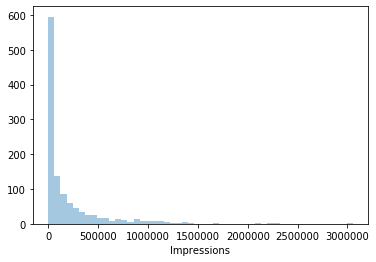

In [9]:
sns.distplot(data.Impressions, kde=False)

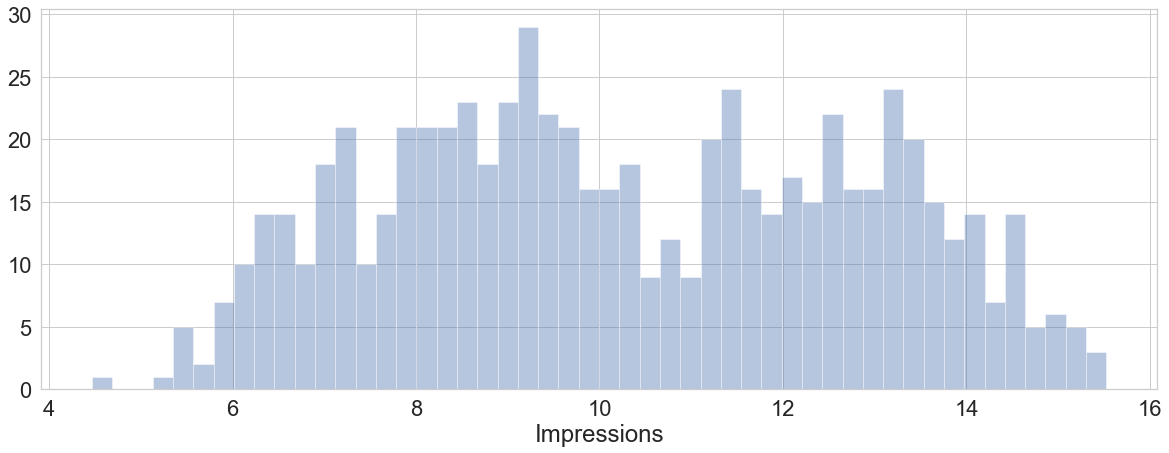

In [14]:
sns.distplot(np.log(data.groupby('fb_campaign_id').Impressions.sum()), kde=False, bins = 50)

In [196]:
#общие настройки графика
sns.set(
    font_scale=2,
    style="whitegrid",
    rc={'figure.figsize':(20,7)}
        )

In [15]:
data['ctr'] = data['Clicks']/data['Impressions']

In [16]:
data['ctr'].describe()

count    1143.000000
mean        0.000164
std         0.000115
min         0.000000
25%         0.000100
50%         0.000160
75%         0.000234
max         0.001059
Name: ctr, dtype: float64

In [18]:
data[(data['ctr'] == data['ctr'].max())]

,ad_id,xyz_campaign_id,fb_campaign_id,age,gender,interest,Impressions,Clicks,Spent,Total_Conversion,Approved_Conversion,ctr
150,738637,936,109857,45-49,F,24,944,1,1.42,1,0,0.001059


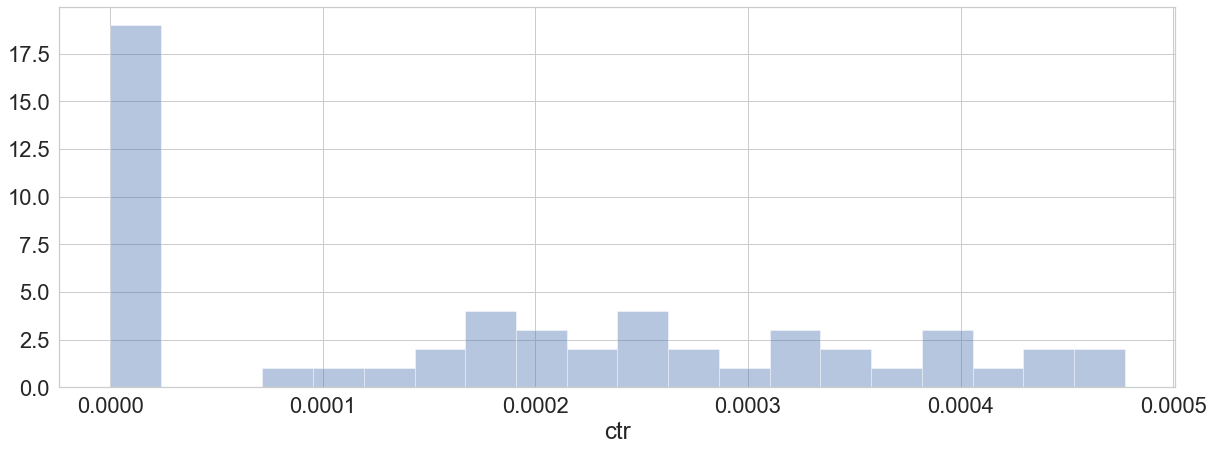

In [26]:
sns.distplot(data.query("xyz_campaign_id == 916").ctr, kde=False, bins = 20)

In [27]:
data['clicksspent'] = data['Spent']/data['Clicks']

In [28]:
data['clicksspent'].describe()

count    936.000000
mean       1.499347
std        0.232879
min        0.180000
25%        1.390000
50%        1.498273
75%        1.644364
max        2.212000
Name: clicksspent, dtype: float64

In [30]:
#межквартильный размах
from scipy.stats import iqr
iqr(data['clicksspent'], nan_policy='omit')

0.2543636990499998

In [32]:
data['age'].drop_duplicates()

0     30-34
18    35-39
27    40-44
32    45-49
Name: age, dtype: object

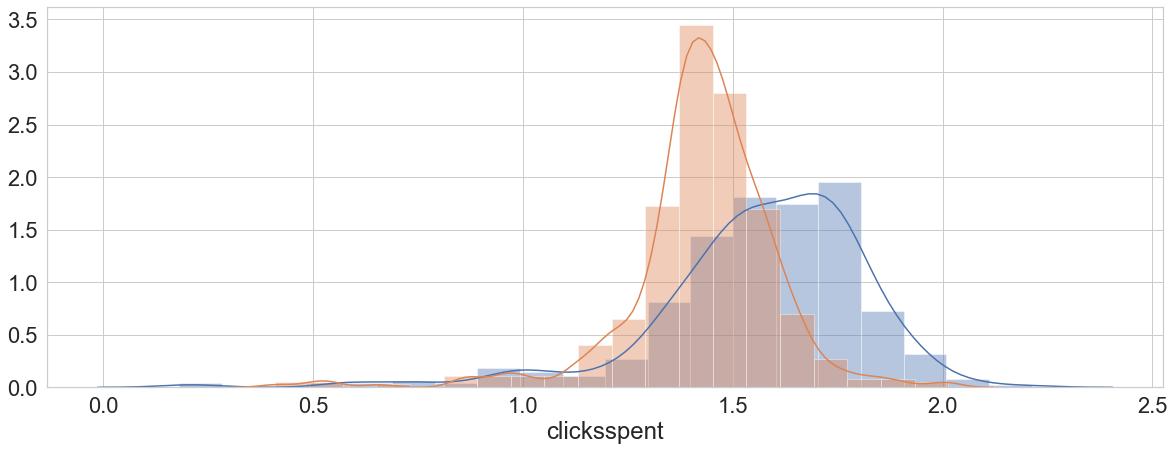

In [33]:
sns.distplot(data.query("gender == 'M'").clicksspent.dropna(), bins = 20)
sns.distplot(data.query("gender == 'F'").clicksspent.dropna(), bins = 20)

In [34]:
data['cc'] = data['Approved_Conversion']/data['Clicks']

In [36]:
data.query("ad_id == 1121814")

,ad_id,xyz_campaign_id,fb_campaign_id,age,gender,interest,Impressions,Clicks,Spent,Total_Conversion,Approved_Conversion,ctr,clicksspent,cc
860,1121814,1178,144659,30-34,F,27,2223278,421,612.300003,38,13,0.000189,1.454394,0.030879


# Урок 3

In [57]:
data = pd.read_csv('data_lessons/london.csv', sep = ',', parse_dates = ['timestamp'])

In [41]:
data.head()

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


In [42]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17414 entries, 0 to 17413
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   timestamp     17414 non-null  datetime64[ns]
 1   cnt           17414 non-null  int64         
 2   t1            17414 non-null  float64       
 3   t2            17414 non-null  float64       
 4   hum           17414 non-null  float64       
 5   wind_speed    17414 non-null  float64       
 6   weather_code  17414 non-null  float64       
 7   is_holiday    17414 non-null  float64       
 8   is_weekend    17414 non-null  float64       
 9   season        17414 non-null  float64       
dtypes: datetime64[ns](1), float64(8), int64(1)
memory usage: 1.3 MB


In [44]:
data.isnull().sum()

timestamp       0
cnt             0
t1              0
t2              0
hum             0
wind_speed      0
weather_code    0
is_holiday      0
is_weekend      0
season          0
dtype: int64

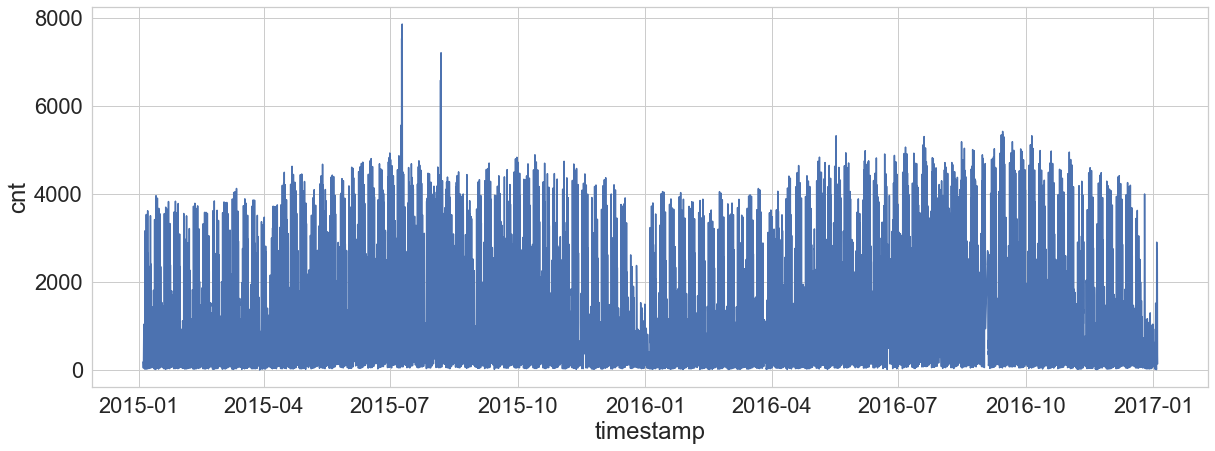

In [45]:
sns.lineplot(x = data.timestamp , y = data.cnt)

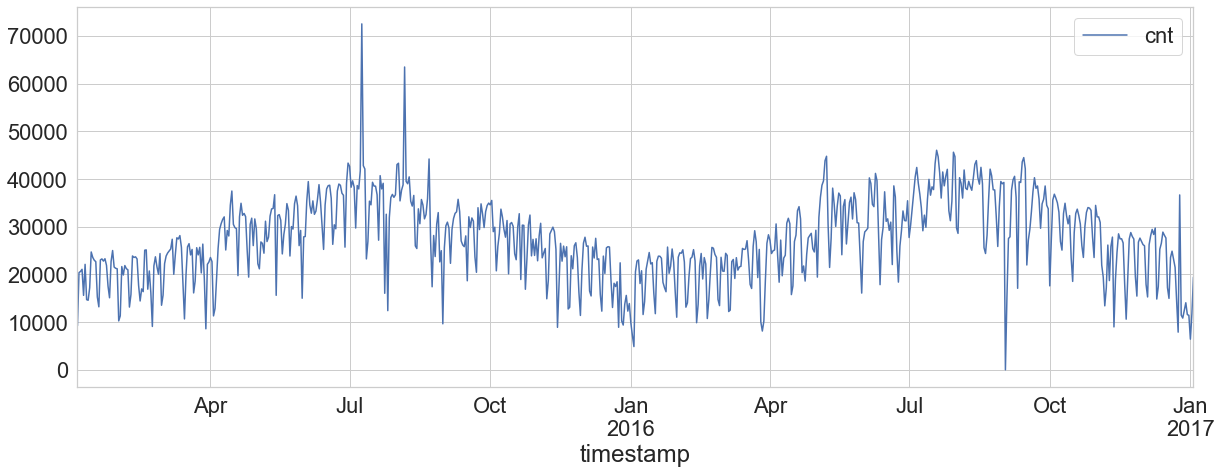

In [62]:
#выведем сумму по дням
data.set_index('timestamp', drop = False, inplace = True) 
data.resample(rule='D').agg({'cnt':'sum'}).plot()

Итак, вы обнаружили на графике некоторые скачки. Давайте проверим, что же могло произойти в тот день 🤔.

Для этого разделим дальнейшие действия на несколько этапов:

- сначала посчитаем скользящее среднее, чтобы сгладить ряд
- далее – разницу между наблюдаемыми и сглаженными значениями
- определим верхние и нижние границы 99% доверительного интервала 
- найдем причины аномалий! \
На данном шаге возьмите агрегированные данные по дням с предыдущего шага и посчитайте скользящее среднее с окном 3. В качестве ответа укажите полученное число аренд за 2015-07-09, округлив значение до целого.

In [83]:
#скользящее среднее
b = data.resample(rule='D').agg({'cnt':'sum'}).rolling(window=3).mean() 
b

,cnt
timestamp,
2015-01-04,NaN
2015-01-05,NaN
2015-01-06,16739.666667
2015-01-07,20683.000000
2015-01-08,19092.666667
...,...
2016-12-30,12682.000000
2016-12-31,12347.333333
2017-01-01,9803.666667


In [84]:
b.loc['2015-07-09']

cnt    50705.0
Name: 2015-07-09 00:00:00, dtype: float64

In [82]:
#разница между скользящим и фактом
a = data.resample(rule='D').agg({'cnt':'sum'}).rolling(window=3).mean() \
            -data.resample(rule='D').agg({'cnt':'sum'})
a

,cnt
timestamp,
2015-01-04,NaN
2015-01-05,NaN
2015-01-06,-3873.333333
2015-01-07,-381.000000
2015-01-08,3491.666667
...,...
2016-12-30,1116.000000
2016-12-31,923.333333
2017-01-01,3382.666667


In [94]:
std = np.std(data.resample(rule='D').agg({'cnt':'sum'}) - \
    data.resample(rule='D').agg({'cnt':'sum'}).rolling(window=3).mean())
np.round(std,2)

cnt    4558.59
dtype: float64

In [103]:
upper = data.resample(rule='D').agg({'cnt':'sum'}).rolling(window=3).mean() + 2.576*std
low = data.resample(rule='D').agg({'cnt':'sum'}).rolling(window=3).mean() - 2.576*std

In [104]:
upper

,cnt
timestamp,
2015-01-04,NaN
2015-01-05,NaN
2015-01-06,28482.585854
2015-01-07,32425.919188
2015-01-08,30835.585854
...,...
2016-12-30,24424.919188
2016-12-31,24090.252521
2017-01-01,21546.585854


In [107]:
c = data.resample(rule='D').agg({'cnt':'sum'})
c['low'] = low
c['upper'] = upper

In [113]:
#выводим значения выше верхнего интервала
c[c['cnt'] > c['upper']]

,cnt,low,upper
timestamp,,,
2015-07-09,72504,38962.080812,62447.919188
2015-08-06,63468,34884.414146,58370.252521
2016-09-04,27512,2516.080812,26001.919188
2016-12-25,36653,7907.747479,31393.585854


In [116]:
data = pd.read_csv('data_lessons/experiment_lesson_4.csv', sep = ',')

In [117]:
data.head()

,order_id,delivery_time,district,experiment_group
0,3159,44.0,Purlieus,control
1,10426,51.0,Purlieus,control
2,9155,46.0,Purlieus,control
3,10699,34.0,Purlieus,control
4,10061,43.0,Purlieus,control


district
Central     AxesSubplot(0.125,0.125;0.775x0.755)
Purlieus    AxesSubplot(0.125,0.125;0.775x0.755)
Suburb      AxesSubplot(0.125,0.125;0.775x0.755)
Name: delivery_time, dtype: object

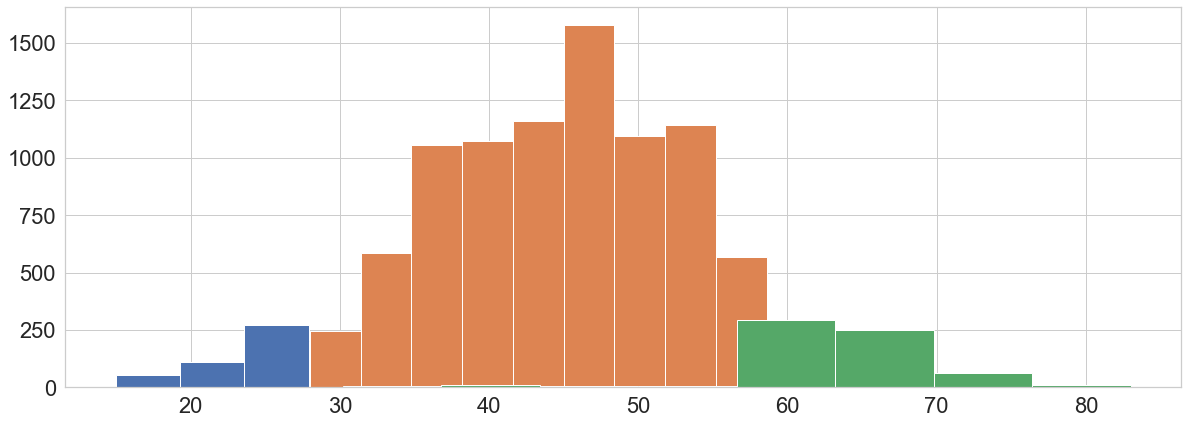

In [123]:
data.query("experiment_group == 'control'").groupby(['district']).delivery_time.hist()

In [124]:
#считаем уникальные значения
data.groupby(['experiment_group']).agg({'order_id': pd.Series.nunique})

,order_id
experiment_group,
control,10092
test,10104


In [126]:
abs(10104-10092)

12

# Normal distribution research  \
Тест Шапиро-Уилка

In [129]:
data[data['experiment_group'] == 'test']['delivery_time'].sample(1000, random_state=17)

17877    37.0
18499    39.0
16476    48.0
14602    30.0
16719    25.0
         ... 
12410    40.0
18882    47.0
15944    47.0
14618    41.0
18816    36.0
Name: delivery_time, Length: 1000, dtype: float64

In [154]:
x = data[data['experiment_group'] == 'test']['delivery_time'].sample(1000, random_state=17).mean()
std = np.std(data[data['experiment_group'] == 'test']['delivery_time'].sample(1000, random_state=17))

In [155]:
std

10.065119919802246

In [150]:
#Шапиро-Уилк - если р value <0.05 - принимаем Н1 о не нормальном распределении
shapiro_test = stats.shapiro(data[data['experiment_group'] == 'test']['delivery_time'].sample(1000, random_state=17))

In [152]:
shapiro_test

(0.9975479245185852, 0.14013493061065674)

In [157]:
#t-test - если р value <0.05 - принимаем Н1 о статистически значимых отличиях средних
stats.ttest_ind(data[data['experiment_group'] == 'test']['delivery_time'],
                     data[data['experiment_group'] == 'control']['delivery_time'])

Ttest_indResult(statistic=-43.03582663183714, pvalue=0.0)

In [158]:
data[data['experiment_group'] == 'test']['delivery_time'].mean()

39.04681314330958

In [159]:
data[data['experiment_group'] == 'control']['delivery_time'].mean()

45.065101070154576

In [161]:
data[data['experiment_group'] == 'test']['delivery_time'].mean()/data[data['experiment_group'] == 'control']['delivery_time'].mean()-1

-0.1335465312166081

# Дисперсионный анализ

- scipy - в модуле stats много различных стат тестов и преобразований
- statsmodels - много моделей

In [177]:
data = pd.read_csv('data_lessons/5_task_1.csv', sep = ',')

In [165]:
data2 = pd.read_csv('data_lessons/5_task_2.csv', sep = ',')

5_task_1: 
- id – id клиента в эксперименте
- group – в каком разрешении показывались картинки (A – прямоугольные 16:9, B – квадратные, C – прямоугольные 12:4)
- events – сколько блюд суммарно было заказано за период

5_task_2:
- id – id клиента в эксперименте
- segment – сегмент (high/low)
- group – вид кнопки (control – старая версия, test – новая версия)
- events – сколько блюд суммарно было заказано за период

In [166]:
data.head()

,id,group,events
0,16046,A,14
1,18712,A,41
2,3268,A,30
3,22633,A,37
4,28071,A,38


In [167]:
data2.head()

,id,group,segment,events
0,83440,test,high,78.0
1,96723,test,high,71.0
2,68719,test,high,80.0
3,50399,test,high,80.0
4,95613,test,high,78.0


Проверьте, являются ли дисперсии внутри групп примерно одинаковыми (гомогенными) с помощью теста Левена.

In [169]:
stats.levene(data.query("group == 'A'")['events'],
                  data.query("group == 'B'")['events'],
                  data.query("group == 'C'")['events'])

LeveneResult(statistic=2.2622596339318037, pvalue=0.1041327199523974)

In [ ]:
#pvalue > 0.05 - не отклоняем нулевую гипотезу

In [170]:
#для интереса сравним стандартные отклонения
print(np.std(data.query("group == 'A'")['events']))
print(np.std(data.query("group == 'B'")['events']))
print(np.std(data.query("group == 'C'")['events']))

10.07887215118834
9.84786753769567
9.958549990334886


In [172]:
#Шапиро-Уилк на нормальность
print(stats.shapiro(data[data['group'] == 'A']['events'].sample(1000, random_state=17)))
print(stats.shapiro(data[data['group'] == 'B']['events'].sample(1000, random_state=17)))
print(stats.shapiro(data[data['group'] == 'C']['events'].sample(1000, random_state=17)))

(0.9973153471946716, 0.09609563648700714)
(0.9980798363685608, 0.31768906116485596)
(0.9981185793876648, 0.3359004259109497)


In [ ]:
#pvalue > 0.05 - не отклоняем нулевую гипотезу - все группы нормально распределены

### для однофакторного дисперсионного анализа используют stats.f_oneway

In [178]:
stats.f_oneway(data[data['group'] == 'A']['events'],
            data[data['group'] == 'B']['events'],
            data[data['group'] == 'C']['events'])

F_onewayResult(statistic=2886.166657438961, pvalue=0.0)

In [182]:
from statsmodels.stats import multicomp

In [201]:
multicomp.pairwise_tukeyhsd(data['events'],groups = data['group']).summary()

group1,group2,meandiff,p-adj,lower,upper,reject
A,B,8.034,0.001,7.7038,8.3642,True
A,C,-2.1093,0.001,-2.4395,-1.7791,True
B,C,-10.1433,0.001,-10.4735,-9.8131,True


In [ ]:
#reject = True - означает, что различия между группами значимые

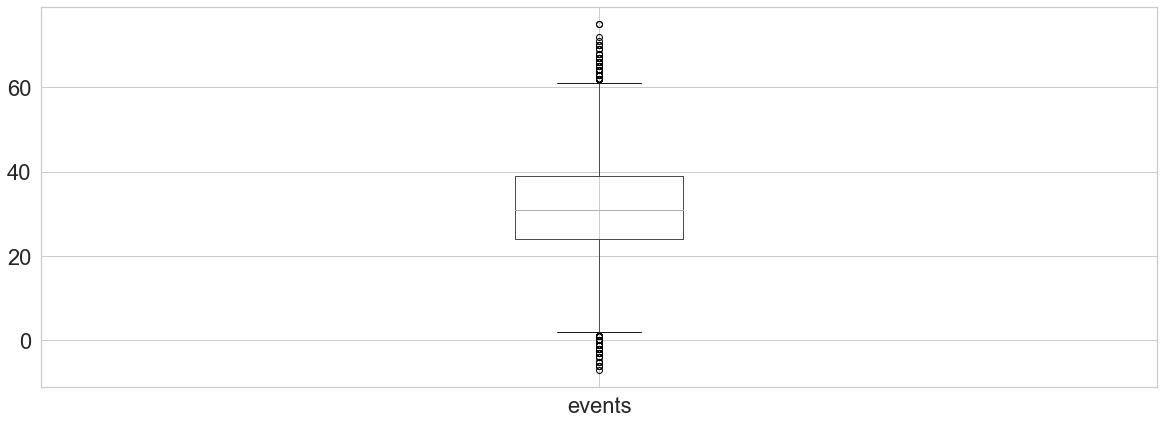

In [203]:
data[['events']].boxplot()

In [205]:
print(data[data['group'] == 'A']['events'].mean())
print(data[data['group'] == 'B']['events'].mean())
print(data[data['group'] == 'C']['events'].mean())

29.5796
37.6136
27.4703


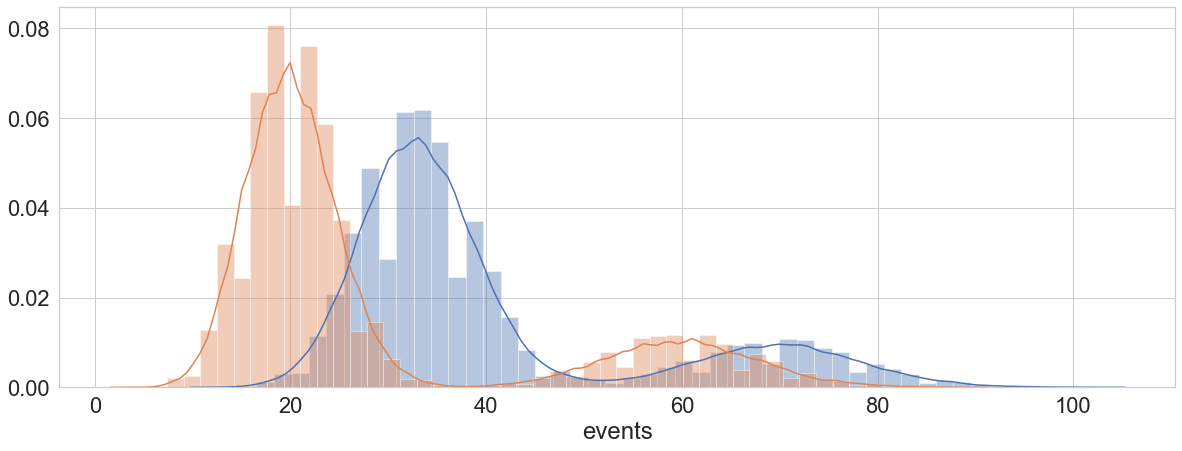

In [207]:
sns.distplot(data2.query("group == 'test'").events)
sns.distplot(data2.query("group == 'control'").events)

In [210]:
data2.groupby(['group','segment']).events.describe()

count       mean       std   min   25%   50%   75%    max
group   segment                                                             
control high     10000.0  59.970800  7.805347  31.0  55.0  60.0  65.0   89.0
        low      40000.0  20.031575  4.473576   4.0  17.0  20.0  23.0   41.0
test    high     10000.0  69.938500  8.403974  40.0  64.0  70.0  76.0  102.0
        low      40000.0  33.025925  5.720845  13.0  29.0  33.0  37.0   59.0

### проверим влияние group , segment на events с опмощью многофакторного дисперсионного анализа
events ~ segment + group + segment:group

In [211]:
moore_lm = ols('events ~ segment + group + segment:group',
                data=data2).fit()
table = sm.stats.anova_lm(moore_lm, typ=2) # Type 2 Anova DataFrame
print(table)

                     sum_sq       df              F         PR(>F)
segment        2.362480e+07      1.0  689756.377485   0.000000e+00
group          3.837195e+06      1.0  112031.864119   0.000000e+00
segment:group  3.664244e+04      1.0    1069.823273  2.060261e-233
Residual       3.424956e+06  99996.0            NaN            NaN


In [216]:
data2['combination'] = data2.group + '/' + data2.segment

In [217]:
data2

,id,group,segment,events,combination
0,83440,test,high,78.0,test/high
1,96723,test,high,71.0,test/high
2,68719,test,high,80.0,test/high
3,50399,test,high,80.0,test/high
4,95613,test,high,78.0,test/high
...,...,...,...,...,...
99995,60695,control,low,15.0,control/low
99996,5934,control,low,16.0,control/low
99997,30046,control,low,22.0,control/low
99998,26474,control,low,21.0,control/low


In [218]:
#Столбец meandiff отражает различие в средних между второй и первой группойs
multicomp.pairwise_tukeyhsd(data2['events'],groups = data2['combination']).summary()

group1,group2,meandiff,p-adj,lower,upper,reject
control/high,control/low,-39.9392,0.001,-40.1073,-39.7711,True
control/high,test/high,9.9677,0.001,9.7551,10.1803,True
control/high,test/low,-26.9449,0.001,-27.113,-26.7768,True
control/low,test/high,49.9069,0.001,49.7388,50.075,True
control/low,test/low,12.9944,0.001,12.888,13.1007,True
test/high,test/low,-36.9126,0.001,-37.0807,-36.7445,True


### Визуализация результатов

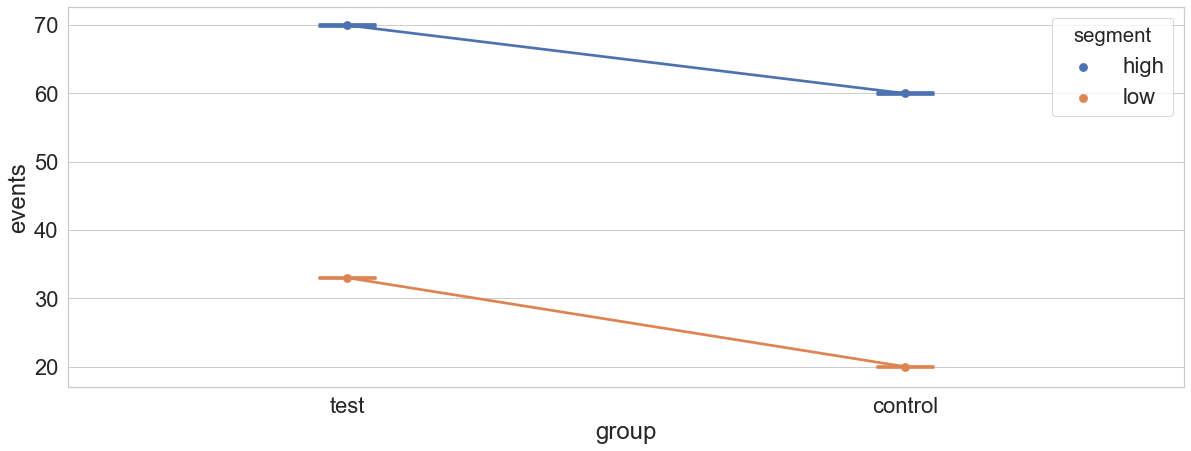

In [224]:
#hue - вывод одного из факторов
sns.pointplot(x = 'group', y = 'events', hue = 'segment', data = data2, capsize = .1)

# Regression

Полезные ссылки:

Лучше обычной корреляции:
https://minepy.readthedocs.io/en/latest/

Квартет энскомба: (для общего понимания)
https://www.autodesk.com/research/publications/same-stats-different-graphs

Диагностика модели:
https://www.statsmodels.org/dev/examples/notebooks/generated/regression_diagnostics.html

Визуальная диагностика:
https://zhiyzuo.github.io/Linear-Regression-Diagnostic-in-Python/


sns.set(style='whitegrid', rc={'figure.figsize' : (10,5)}) 
sns.regplot(x = 'sepal_length', y = 'sepal_width', data = iris)
plt.title('Взаимосвязь измерений чашелистников ирисов')
plt.xlabel('Длина чашелистника')
plt.ylabel('Ширина чашелистника')

In [226]:
data = pd.read_csv('data_lessons/cars.csv')

In [227]:
data.head()

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


In [228]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   car_ID            205 non-null    int64  
 1   symboling         205 non-null    int64  
 2   CarName           205 non-null    object 
 3   fueltype          205 non-null    object 
 4   aspiration        205 non-null    object 
 5   doornumber        205 non-null    object 
 6   carbody           205 non-null    object 
 7   drivewheel        205 non-null    object 
 8   enginelocation    205 non-null    object 
 9   wheelbase         205 non-null    float64
 10  carlength         205 non-null    float64
 11  carwidth          205 non-null    float64
 12  carheight         205 non-null    float64
 13  curbweight        205 non-null    int64  
 14  enginetype        205 non-null    object 
 15  cylindernumber    205 non-null    object 
 16  enginesize        205 non-null    int64  
 1

In [236]:
data['CarName'] = data['CarName'].apply(lambda x: x.split(' ')[0]) 

In [237]:
data['CarName'].head()

0    alfa-romero
1    alfa-romero
2    alfa-romero
3           audi
4           audi
Name: CarName, dtype: object

In [239]:
len(data['CarName'].drop_duplicates())

28

'maxda' → 'mazda'
'Nissan' → 'nissan'
'porcshce' → 'porsche'
'toyouta' → 'toyota'
'vokswagen' & 'vw' → 'volkswagen'

In [240]:
fact = ['maxda' ,'Nissan', 'porcshce' , 'toyouta', 'vokswagen', 'vw']
correct = ['mazda', 'nissan', 'porsche', 'toyota' , 'volkswagen', 'volkswagen']

In [241]:
for fact, correct in zip(fact,correct):
    data['CarName'] = data['CarName'].apply(lambda x: x.replace(fact, correct)) 

In [243]:
len(data['CarName'].drop_duplicates())

22

In [244]:
data.corr()

,car_ID,symboling,wheelbase,carlength,carwidth,carheight,curbweight,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
car_ID,1.000000,-0.151621,0.129729,0.170636,0.052387,0.255960,0.071962,-0.033930,0.260064,-0.160824,0.150276,-0.015006,-0.203789,0.015940,0.011255,-0.109093
symboling,-0.151621,1.000000,-0.531954,-0.357612,-0.232919,-0.541038,-0.227691,-0.105790,-0.130051,-0.008735,-0.178515,0.070873,0.273606,-0.035823,0.034606,-0.079978
wheelbase,0.129729,-0.531954,1.000000,0.874587,0.795144,0.589435,0.776386,0.569329,0.488750,0.160959,0.249786,0.353294,-0.360469,-0.470414,-0.544082,0.577816
carlength,0.170636,-0.357612,0.874587,1.000000,0.841118,0.491029,0.877728,0.683360,0.606454,0.129533,0.158414,0.552623,-0.287242,-0.670909,-0.704662,0.682920
carwidth,0.052387,-0.232919,0.795144,0.841118,1.000000,0.279210,0.867032,0.735433,0.559150,0.182942,0.181129,0.640732,-0.220012,-0.642704,-0.677218,0.759325
carheight,0.255960,-0.541038,0.589435,0.491029,0.279210,1.000000,0.295572,0.067149,0.171071,-0.055307,0.261214,-0.108802,-0.320411,-0.048640,-0.107358,0.119336
curbweight,0.071962,-0.227691,0.776386,0.877728,0.867032,0.295572,1.000000,0.850594,0.648480,0.168790,0.151362,0.750739,-0.266243,-0.757414,-0.797465,0.835305
enginesize,-0.033930,-0.105790,0.569329,0.683360,0.735433,0.067149,0.850594,1.000000,0.583774,0.203129,0.028971,0.809769,-0.244660,-0.653658,-0.677470,0.874145
boreratio,0.260064,-0.130051,0.488750,0.606454,0.559150,0.171071,0.648480,0.583774,1.000000,-0.055909,0.005197,0.573677,-0.254976,-0.584532,-0.587012,0.553173
stroke,-0.160824,-0.008735,0.160959,0.129533,0.182942,-0.055307,0.168790,0.203129,-0.055909,1.000000,0.186110,0.080940,-0.067964,-0.042145,-0.043931,0.079443


In [284]:
# data = data.drop(columns = ['car_ID'])
features = list(data[['CarName', 'fueltype', 'aspiration','carbody', 'drivewheel', 
                             'wheelbase', 'carlength','carwidth', 'curbweight', 
                             'enginetype', 'cylindernumber', 'enginesize', 'boreratio',
                             'horsepower']].columns)
itog_columns = []
for f in features:
    if str(data[f].dtype) == 'object':
        itog_columns.append(f)


In [257]:
itog_columns

['CarName',
 'fueltype',
 'aspiration',
 'doornumber',
 'carbody',
 'drivewheel',
 'enginelocation',
 'enginetype',
 'cylindernumber',
 'fuelsystem']

In [260]:
data

,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,3,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,3,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,1,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,171.2,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,2,audi,gas,std,four,sedan,fwd,front,99.8,176.6,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,2,audi,gas,std,four,sedan,4wd,front,99.4,176.6,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,-1,volvo,gas,std,four,sedan,rwd,front,109.1,188.8,...,141,mpfi,3.78,3.15,9.5,114,5400,23,28,16845.0
201,-1,volvo,gas,turbo,four,sedan,rwd,front,109.1,188.8,...,141,mpfi,3.78,3.15,8.7,160,5300,19,25,19045.0
202,-1,volvo,gas,std,four,sedan,rwd,front,109.1,188.8,...,173,mpfi,3.58,2.87,8.8,134,5500,18,23,21485.0
203,-1,volvo,diesel,turbo,four,sedan,rwd,front,109.1,188.8,...,145,idi,3.01,3.40,23.0,106,4800,26,27,22470.0


In [285]:
#трансформируем категориальные переменные в бинарные
df_dummy = pd.get_dummies(data=data[['CarName', 'fueltype', 'aspiration','carbody', 'drivewheel', 
                             'wheelbase', 'carlength','carwidth', 'curbweight', 
                             'enginetype', 'cylindernumber', 'enginesize', 'boreratio',
                             'horsepower']][itog_columns], drop_first = True)

In [264]:
df_dummy

,CarName_audi,CarName_bmw,CarName_buick,CarName_chevrolet,CarName_dodge,CarName_honda,CarName_isuzu,CarName_jaguar,CarName_mazda,CarName_mercury,...,cylindernumber_three,cylindernumber_twelve,cylindernumber_two,fuelsystem_2bbl,fuelsystem_4bbl,fuelsystem_idi,fuelsystem_mfi,fuelsystem_mpfi,fuelsystem_spdi,fuelsystem_spfi
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
201,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
202,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
203,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [286]:
data_itog = pd.concat([data[['CarName', 'fueltype', 'aspiration','carbody', 'drivewheel', 
                             'wheelbase', 'carlength','carwidth', 'curbweight', 
                             'enginetype', 'cylindernumber', 'enginesize', 'boreratio',
                             'horsepower']], df_dummy], axis=1)
data_itog.head()

,CarName,fueltype,aspiration,carbody,drivewheel,wheelbase,carlength,carwidth,curbweight,enginetype,...,enginetype_ohc,enginetype_ohcf,enginetype_ohcv,enginetype_rotor,cylindernumber_five,cylindernumber_four,cylindernumber_six,cylindernumber_three,cylindernumber_twelve,cylindernumber_two
0,alfa-romero,gas,std,convertible,rwd,88.6,168.8,64.1,2548,dohc,...,0,0,0,0,0,1,0,0,0,0
1,alfa-romero,gas,std,convertible,rwd,88.6,168.8,64.1,2548,dohc,...,0,0,0,0,0,1,0,0,0,0
2,alfa-romero,gas,std,hatchback,rwd,94.5,171.2,65.5,2823,ohcv,...,0,0,1,0,0,0,1,0,0,0
3,audi,gas,std,sedan,fwd,99.8,176.6,66.2,2337,ohc,...,1,0,0,0,0,1,0,0,0,0
4,audi,gas,std,sedan,4wd,99.4,176.6,66.4,2824,ohc,...,1,0,0,0,1,0,0,0,0,0


In [287]:
data_itog = pd.concat([data[list(set(['CarName', 'fueltype', 'aspiration','carbody', 'drivewheel', 
                             'wheelbase', 'carlength','carwidth', 'curbweight', 
                             'enginetype', 'cylindernumber', 'enginesize', 'boreratio',
                             'horsepower', 'price'])-set(itog_columns))], df_dummy], axis=1)

In [289]:
data_itog

,horsepower,curbweight,boreratio,carwidth,price,wheelbase,enginesize,carlength,CarName_audi,CarName_bmw,...,enginetype_ohc,enginetype_ohcf,enginetype_ohcv,enginetype_rotor,cylindernumber_five,cylindernumber_four,cylindernumber_six,cylindernumber_three,cylindernumber_twelve,cylindernumber_two
0,111,2548,3.47,64.1,13495.0,88.6,130,168.8,0,0,...,0,0,0,0,0,1,0,0,0,0
1,111,2548,3.47,64.1,16500.0,88.6,130,168.8,0,0,...,0,0,0,0,0,1,0,0,0,0
2,154,2823,2.68,65.5,16500.0,94.5,152,171.2,0,0,...,0,0,1,0,0,0,1,0,0,0
3,102,2337,3.19,66.2,13950.0,99.8,109,176.6,1,0,...,1,0,0,0,0,1,0,0,0,0
4,115,2824,3.19,66.4,17450.0,99.4,136,176.6,1,0,...,1,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,114,2952,3.78,68.9,16845.0,109.1,141,188.8,0,0,...,1,0,0,0,0,1,0,0,0,0
201,160,3049,3.78,68.8,19045.0,109.1,141,188.8,0,0,...,1,0,0,0,0,1,0,0,0,0
202,134,3012,3.58,68.9,21485.0,109.1,173,188.8,0,0,...,0,0,1,0,0,0,1,0,0,0
203,106,3217,3.01,68.9,22470.0,109.1,145,188.8,0,0,...,1,0,0,0,0,0,1,0,0,0


In [288]:
len(data_itog.columns)

49

### Строим модель

In [290]:
import statsmodels.api as sm

In [330]:
model = sm.OLS(data_itog['price'].values, data_itog['horsepower'].values)
results = model.fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.901
Model:                            OLS   Adj. R-squared (uncentered):              0.900
Method:                 Least Squares   F-statistic:                              1854.
Date:                Sun, 11 Apr 2021   Prob (F-statistic):                   2.43e-104
Time:                        00:59:42   Log-Likelihood:                         -2031.7
No. Observations:                 205   AIC:                                      4065.
Df Residuals:                     204   BIC:                                      4069.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [333]:
model = sm.OLS(data_itog['price'].values, np.asarray(data_itog.drop(columns = ['price'])))
results = model.fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.989
Model:                            OLS   Adj. R-squared (uncentered):              0.985
Method:                 Least Squares   F-statistic:                              300.8
Date:                Sun, 11 Apr 2021   Prob (F-statistic):                   2.09e-133
Time:                        01:00:43   Log-Likelihood:                         -1809.7
No. Observations:                 205   AIC:                                      3711.
Df Residuals:                     159   BIC:                                      3864.
Df Model:                          46                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [298]:
from statsmodels.sandbox.regression.predstd import wls_prediction_std

## OLS non-linear curve but linear in parameters

In [313]:
#We simulate artificial data with a non-linear relationship between x and y:

nsample = 50
sig = 0.5
x = np.linspace(0, 20, nsample)
X = np.column_stack((x, np.sin(x), (x-5)**2, np.ones(nsample)))
beta = [0.5, 0.5, -0.02, 5.]

y_true = np.dot(X, beta)
y = y_true + sig * np.random.normal(size=nsample)


In [304]:
res = sm.OLS(y, X).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.938
Model:                            OLS   Adj. R-squared:                  0.934
Method:                 Least Squares   F-statistic:                     233.2
Date:                Sun, 11 Apr 2021   Prob (F-statistic):           7.96e-28
Time:                        00:41:30   Log-Likelihood:                -33.242
No. Observations:                  50   AIC:                             74.48
Df Residuals:                      46   BIC:                             82.13
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.4968      0.026     19.271      0.0

In [305]:
print('Parameters: ', res.params)
print('Standard errors: ', res.bse)
print('Predicted values: ', res.predict())

Parameters:  [ 0.49683806  0.42239692 -0.01982039  5.03962238]
Standard errors:  [0.02578166 0.10135074 0.00226365 0.16716926]
Predicted values:  [ 4.54411252  4.99216064  5.40605874  5.76278654  6.04763168  6.25660687
  6.39710505  6.48668467  6.55018495  6.61564484  6.70969631  6.8531888
  7.05776367  7.32394162  7.6410371   7.98891394  8.34129365  8.67007288
  8.94994079  9.16253747  9.29947046  9.36369363  9.36902181  9.33786111
  9.29752761  9.27575945  9.29615949  9.37431747  9.51524863  9.71256971
  9.94954774 10.20184921 10.44153795 10.64166502 10.78069634 10.84605064
 10.83616654 10.76075913 10.63922373 10.49744936 10.36356519 10.26331905
 10.2158471  10.23052983 10.30545087 10.42771182 10.57555145 10.72192102
 10.83892826 10.90242004]


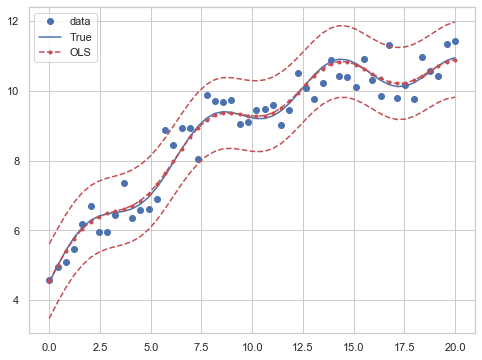

In [306]:
#wls_prediction_std возвращает стандартное отклонение и доверительный интервал данных
prstd, iv_l, iv_u = wls_prediction_std(res)

fig, ax = plt.subplots(figsize=(8,6))

ax.plot(x, y, 'o', label="data")
ax.plot(x, y_true, 'b-', label="True")
ax.plot(x, res.fittedvalues, 'r--.', label="OLS")
ax.plot(x, iv_u, 'r--')
ax.plot(x, iv_l, 'r--')
ax.legend(loc='best')

# А/А  тесты

In [344]:
data = pd.read_csv('data_lessons/hw_aa.csv', sep = ';')

In [345]:
data.head()

,Unnamed: 0,uid,experimentVariant,version,purchase
0,1,c4ca4238a0b923820dcc509a6f75849b,1,v2.8.0,0
1,2,c81e728d9d4c2f636f067f89cc14862c,0,v2.9.0,0
2,3,eccbc87e4b5ce2fe28308fd9f2a7baf3,1,v2.9.0,0
3,4,a87ff679a2f3e71d9181a67b7542122c,1,v2.8.0,0
4,5,e4da3b7fbbce2345d7772b0674a318d5,1,v2.8.0,0


In [347]:
from tqdm.auto import tqdm

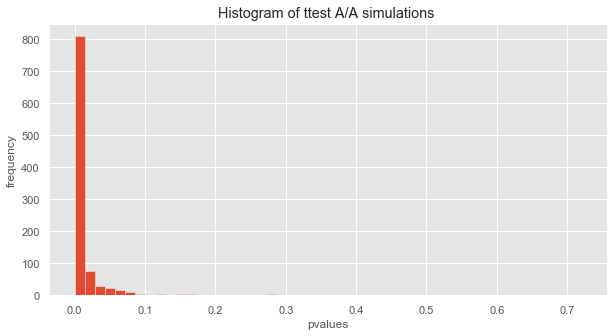

0.924

In [349]:
#p-value должен получиться меньше 0.05
n = 100000
simulations = 1000
n_s = 1000
res = []


# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = data[(data['experimentVariant'] == 1)]['purchase'].sample(n_s, replace = False).values
    s2 = data[(data['experimentVariant'] == 0)]['purchase'].sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations